In [1]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# google cloud packages
from google.cloud import storage
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

# install google cloud storage library
!pip install google-cloud-storage

# authenticate with google cloud storage
auth.authenticate_user()

In [2]:
# setup code for use with google cloud storage and bigquery

# google cloud project setup
project_id = "mimic-project-451516"

# instantiate client for google cloud storage and bigquery
gcs_client = storage.Client(project=project_id)

# instantiate client for biqquery
bq_client = bigquery.Client(project=project_id)

# instantiate MIMIC-III storage bucket
bucket_name = "mimiciii-1.4.physionet.org"

In [3]:
# check available files in the bucket by printing list of files
print(f"Files in GCS bucket: {bucket_name}")

# instantiate bucket and store files in blob
gcs_bucket = gcs_client.bucket(bucket_name, user_project=project_id)
blobs = gcs_bucket.list_blobs()
file_list = [blob.name for blob in blobs]

# format so that files and their list index are present for quick access later
df_files = pd.DataFrame({
    "Index": range(len(file_list)),
    "Filename": file_list
})

# filter only on csv files that contain patient data
df_files = df_files[df_files['Filename'].str.endswith('.csv.gz')]

print(df_files.to_string(index=False))

Files in GCS bucket: mimiciii-1.4.physionet.org
 Index                  Filename
     0         ADMISSIONS.csv.gz
     1            CALLOUT.csv.gz
     2         CAREGIVERS.csv.gz
     3        CHARTEVENTS.csv.gz
     4          CPTEVENTS.csv.gz
     5     DATETIMEEVENTS.csv.gz
     6      DIAGNOSES_ICD.csv.gz
     7           DRGCODES.csv.gz
     8              D_CPT.csv.gz
     9    D_ICD_DIAGNOSES.csv.gz
    10   D_ICD_PROCEDURES.csv.gz
    11            D_ITEMS.csv.gz
    12         D_LABITEMS.csv.gz
    13           ICUSTAYS.csv.gz
    14     INPUTEVENTS_CV.csv.gz
    15     INPUTEVENTS_MV.csv.gz
    16          LABEVENTS.csv.gz
    18 MICROBIOLOGYEVENTS.csv.gz
    19         NOTEEVENTS.csv.gz
    20       OUTPUTEVENTS.csv.gz
    21           PATIENTS.csv.gz
    22      PRESCRIPTIONS.csv.gz
    23 PROCEDUREEVENTS_MV.csv.gz
    24     PROCEDURES_ICD.csv.gz
    26           SERVICES.csv.gz
    28          TRANSFERS.csv.gz


In [4]:
# define function to load each csv file either by downloading or using bigquery query
def load_file_results_to_df(file_path=None, query=None, bucket=gcs_bucket, client=None):

    # load csv file directly from google cloud storage (for files that are smaller)
    if file_path:
        blob = bucket.blob(file_path)
        blob.download_to_filename(file_path)
        df = pd.read_csv(file_path, compression="gzip")

    # load csv file after applying query using bigquery (for larger files)
    elif query:
        df = bq_client.query(query).to_dataframe()
        print("Query executed and loaded to DataFrame using BigQuery")

    # count number of rows in dataframe and print message
    row_count = len(df)
    print(f"DataFrame with {row_count} row(s) has been returned.")

    return df

In [5]:
admissions_df = load_file_results_to_df(file_path=file_list[0])

DataFrame with 58976 row(s) has been returned.


In [6]:
admissions_df.info()
admissions_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1


In [7]:
# check for duplicate patients
duplicate_subject_id_count = admissions_df.duplicated(subset=['SUBJECT_ID']).sum()
print(f"Number of duplicate SUBJECT_IDs is: {duplicate_subject_id_count}")

Number of duplicate SUBJECT_IDs is: 12456


In [8]:
# check for duplicate admissions
duplicate_hadm_id_count = admissions_df.duplicated(subset=['HADM_ID']).sum()
print(f"Number of duplicate HADM_IDs is: {duplicate_hadm_id_count}")

Number of duplicate HADM_IDs is: 0


In [9]:
pd.set_option('display.max_rows', None)

In [10]:
# create view of mortality across admissions dataset
mortality_counts_df = admissions_df.groupby(['ETHNICITY', 'HOSPITAL_EXPIRE_FLAG']).size().unstack(fill_value=0)
mortality_counts_df.columns = ['Survived', 'Died']

# add mortality rate to dataframe
mortality_counts_df['Mortality Rate'] = (mortality_counts_df['Died'] / ( mortality_counts_df['Survived'] + mortality_counts_df['Died']) * 100).round(2)

# organise by increasing mortality across the ethnicities
mortality_counts_df.sort_values(by='Mortality Rate', ascending=False)

,Survived,Died,Mortality Rate
ETHNICITY,,,
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,2,1,33.33
ASIAN - JAPANESE,5,2,28.57
ASIAN - CAMBODIAN,13,4,23.53
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,14,4,22.22
UNABLE TO OBTAIN,656,158,19.41
UNKNOWN/NOT SPECIFIED,3784,739,16.34
WHITE - RUSSIAN,142,22,13.41
ASIAN - OTHER,15,2,11.76
ASIAN - VIETNAMESE,47,6,11.32


In [11]:
# reviewing missingness across the admissions dataset
admissions_null_values_df = admissions_df.isnull().sum().reset_index()
admissions_null_values_df.columns = ['Column', 'Missing Count']
admissions_null_values_df.sort_values(by='Missing Count', ascending=False)

,Column,Missing Count
5,DEATHTIME,53122
14,EDREGTIME,28099
15,EDOUTTIME,28099
10,LANGUAGE,25332
12,MARITAL_STATUS,10128
11,RELIGION,458
16,DIAGNOSIS,25
2,HADM_ID,0
1,SUBJECT_ID,0
0,ROW_ID,0


In [12]:
# show unique value counts for INSURANCE
insurance_unique_values = admissions_df['INSURANCE'].value_counts()
insurance_unique_values

,count
INSURANCE,
Medicare,28215
Private,22582
Medicaid,5785
Government,1783
Self Pay,611


In [13]:
# show unique value counts for LANGUAGE
language_unique_values = admissions_df['LANGUAGE'].value_counts()
language_unique_values

,count
LANGUAGE,
ENGL,29086
SPAN,1083
RUSS,790
PTUN,628
CANT,413
PORT,342
CAPE,256
MAND,156
HAIT,150


In [14]:
# show unique value counts for Religion
religion_unique_values = admissions_df['RELIGION'].value_counts()
religion_unique_values

,count
RELIGION,
CATHOLIC,20606
NOT SPECIFIED,11753
UNOBTAINABLE,8269
PROTESTANT QUAKER,7134
JEWISH,5314
OTHER,2696
EPISCOPALIAN,774
GREEK ORTHODOX,459
CHRISTIAN SCIENTIST,429


In [15]:
# show unique value counts for Marital Status
marital_unique_values = admissions_df['MARITAL_STATUS'].value_counts()
marital_unique_values

,count
MARITAL_STATUS,
MARRIED,24239
SINGLE,13254
WIDOWED,7211
DIVORCED,3213
SEPARATED,571
UNKNOWN (DEFAULT),345
LIFE PARTNER,15


In [16]:
# show unique value counts for ADMISSION_TYPE
admission_type_unique_values = admissions_df['ADMISSION_TYPE'].value_counts()
admission_type_unique_values

,count
ADMISSION_TYPE,
EMERGENCY,42071
NEWBORN,7863
ELECTIVE,7706
URGENT,1336


In [17]:
# show unique value counts for ADMISSION_LOCATION
admission_location_unique_values = admissions_df['ADMISSION_LOCATION'].value_counts()
admission_location_unique_values

,count
ADMISSION_LOCATION,
EMERGENCY ROOM ADMIT,22754
PHYS REFERRAL/NORMAL DELI,15079
CLINIC REFERRAL/PREMATURE,12032
TRANSFER FROM HOSP/EXTRAM,8456
TRANSFER FROM SKILLED NUR,273
** INFO NOT AVAILABLE **,204
HMO REFERRAL/SICK,102
TRANSFER FROM OTHER HEALT,71
TRSF WITHIN THIS FACILITY,5


In [18]:
# show unique value counts for Ethnicity
ethnicity_unique_values = admissions_df['ETHNICITY'].value_counts().reset_index()
ethnicity_unique_values.columns = ['ETHNICITY', 'COUNT']
ethnicity_unique_values['PERCENT'] = ((ethnicity_unique_values['COUNT'] / ethnicity_unique_values['COUNT'].sum()) * 100).round(2)
ethnicity_unique_values

,ETHNICITY,COUNT,PERCENT
0,WHITE,40996,69.51
1,BLACK/AFRICAN AMERICAN,5440,9.22
2,UNKNOWN/NOT SPECIFIED,4523,7.67
3,HISPANIC OR LATINO,1696,2.88
4,OTHER,1512,2.56
5,ASIAN,1509,2.56
6,UNABLE TO OBTAIN,814,1.38
7,PATIENT DECLINED TO ANSWER,559,0.95
8,ASIAN - CHINESE,277,0.47
9,HISPANIC/LATINO - PUERTO RICAN,232,0.39


In [19]:
# group ethnicities where applicable into new column using broader grouping
admissions_df['ETHNICITY_GROUP'] = admissions_df['ETHNICITY'].apply(
    lambda x: 'ASIAN' if 'ASIAN' in str(x) else (
        'BLACK' if 'BLACK' in str(x) else (
            'HISPANIC OR LATINO' if ('HISPANIC/LATINO' in str(x)) else (
        'WHITE' if 'WHITE' in str(x) else x
        )
    )
)
)

In [20]:
# group by ethnicity group and count for each group
ethnicities_df = admissions_df.groupby('ETHNICITY_GROUP').size().reset_index()
ethnicities_df.columns = ['ETHNICITY', 'COUNT']
ethnicities_df['PERCENT'] = ((ethnicities_df['COUNT'] / ethnicities_df['COUNT'].sum()) * 100).round(2)
ethnicities_sorted_df = ethnicities_df.sort_values(by='COUNT', ascending=False)
ethnicities_sorted_df

,ETHNICITY,COUNT,PERCENT
15,WHITE,41325,70.07
3,BLACK,5785,9.81
14,UNKNOWN/NOT SPECIFIED,4523,7.67
5,HISPANIC OR LATINO,2128,3.61
2,ASIAN,2007,3.40
9,OTHER,1512,2.56
13,UNABLE TO OBTAIN,814,1.38
10,PATIENT DECLINED TO ANSWER,559,0.95
7,MULTI RACE ETHNICITY,130,0.22
11,PORTUGUESE,61,0.10


In [21]:
# calculate percentage representation for each ethnicity listed
ethnicities_sorted_df['PERCENT'] = ((ethnicities_sorted_df['COUNT'] / len(admissions_df)) * 100).round(2)

# sort filtered df by ascend percent
ethnicities_percent_sorted_df = ethnicities_sorted_df.sort_values(by='PERCENT', ascending=False)

# print the filtered dataframe
ethnicities_percent_sorted_df

,ETHNICITY,COUNT,PERCENT
15,WHITE,41325,70.07
3,BLACK,5785,9.81
14,UNKNOWN/NOT SPECIFIED,4523,7.67
5,HISPANIC OR LATINO,2128,3.61
2,ASIAN,2007,3.40
9,OTHER,1512,2.56
13,UNABLE TO OBTAIN,814,1.38
10,PATIENT DECLINED TO ANSWER,559,0.95
7,MULTI RACE ETHNICITY,130,0.22
11,PORTUGUESE,61,0.10


In [22]:
# create view of mortality across admissions dataset
mortality_counts_df = admissions_df.groupby(['ETHNICITY_GROUP', 'HOSPITAL_EXPIRE_FLAG']).size().unstack(fill_value=0)
mortality_counts_df.columns = ['SURVIVED', 'DIED']

# add mortality rate to dataframe
mortality_counts_df['MORTALITY RATE'] = (mortality_counts_df['DIED'] / ( mortality_counts_df['SURVIVED'] + mortality_counts_df['DIED']) * 100).round(2)

# organise by increasing mortality across the ethnicities
mortality_counts_df.sort_values(by='MORTALITY RATE', ascending=False)

,SURVIVED,DIED,MORTALITY RATE
ETHNICITY_GROUP,,,
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,2,1,33.33
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,14,4,22.22
UNABLE TO OBTAIN,656,158,19.41
UNKNOWN/NOT SPECIFIED,3784,739,16.34
WHITE,37246,4079,9.87
OTHER,1390,122,8.07
ASIAN,1855,152,7.57
PATIENT DECLINED TO ANSWER,518,41,7.33
BLACK,5364,421,7.28


In [23]:
print('The overall mortality rate: ')
print((mortality_counts_df['DIED'].sum() / ( mortality_counts_df['SURVIVED'].sum() + mortality_counts_df['DIED'].sum()) * 100).round(2))

print('Total patient deaths: ')
print((mortality_counts_df['DIED'].sum()))

print('Total surviving patients: ')
print((mortality_counts_df['SURVIVED'].sum()))

print('Total number of patients: ')
print((mortality_counts_df['DIED'].sum()) + mortality_counts_df['SURVIVED'].sum())


The overall mortality rate: 
9.93
Total patient deaths: 
5854
Total surviving patients: 
53122
Total number of patients: 
58976


In [24]:
# convert relevant admissions columns to datetime
admissions_df["ADMITTIME"] = pd.to_datetime(admissions_df["ADMITTIME"])
admissions_df["DISCHTIME"] = pd.to_datetime(admissions_df["DISCHTIME"])

# calculate length of stay in days as new column
admissions_df["HOSPITAL_LENGTH"] = ((admissions_df["DISCHTIME"] - admissions_df["ADMITTIME"]).dt.total_seconds() / (24 * 3600)).round().astype(int)

# calculate average length of stay for patients who died
avg_length_of_stay_died = admissions_df[admissions_df['HOSPITAL_EXPIRE_FLAG'] == 1]['HOSPITAL_LENGTH'].mean()
print(f'Average length of stay for patients who died: {avg_length_of_stay_died:.2f}')

# calculate average length of stay for patients who survived
avg_length_of_stay_survived = admissions_df[admissions_df['HOSPITAL_EXPIRE_FLAG'] == 0]['HOSPITAL_LENGTH'].mean()
print(f'Average length of stay for patients who survived: {avg_length_of_stay_survived:.2f}')

Average length of stay for patients who died: 10.13
Average length of stay for patients who survived: 10.16


In [25]:
#  calculate min hospital length
min_hosp_length = admissions_df['HOSPITAL_LENGTH'].min()
print(f'Minimum length of stay for any patient: {min_hosp_length:.2f}')
# calculate max hospital length
max_hosp_length = admissions_df['HOSPITAL_LENGTH'].max()
print(f'Maximum length of stay for any patient: {max_hosp_length:.2f}')

Minimum length of stay for any patient: -1.00
Maximum length of stay for any patient: 295.00


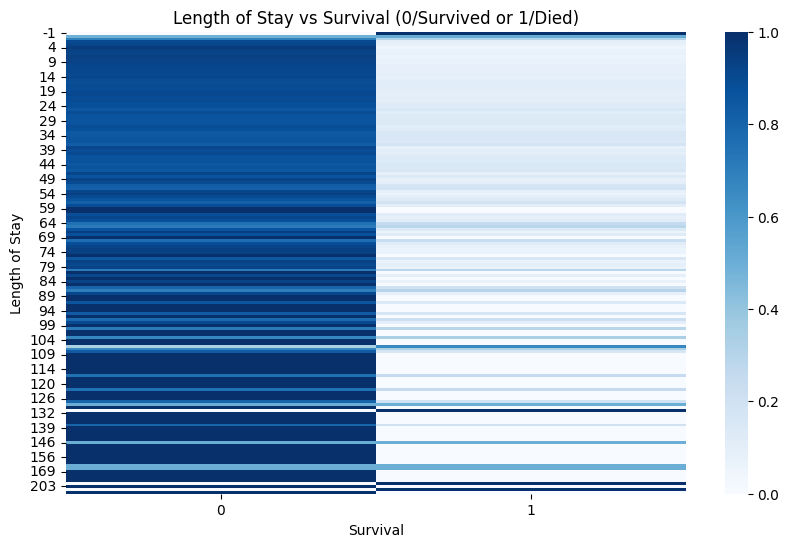

In [26]:
# visualise in heatmap correlation between length of time spent in hospital and survival
data_length_of_stay_survival = pd.crosstab(admissions_df['HOSPITAL_LENGTH'], admissions_df['HOSPITAL_EXPIRE_FLAG'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_length_of_stay_survival, cmap='Blues')
plt.title('Length of Stay vs Survival (0/Survived or 1/Died)')
plt.xlabel('Survival')
plt.ylabel('Length of Stay')
plt.show()

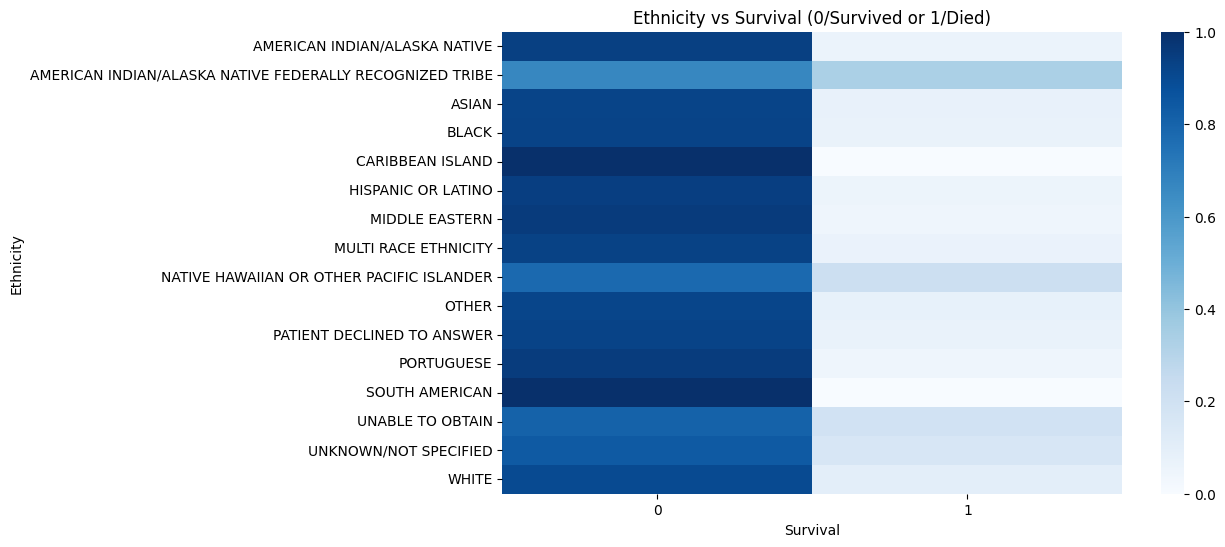

In [27]:
# visualise in heatmap correlation between ethnicity group and survival
data_ethnicity_religion = pd.crosstab(admissions_df['ETHNICITY_GROUP'], admissions_df['HOSPITAL_EXPIRE_FLAG'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_ethnicity_religion, cmap='Blues')
plt.title('Ethnicity vs Survival (0/Survived or 1/Died)')
plt.xlabel('Survival')
plt.ylabel('Ethnicity')
plt.show()

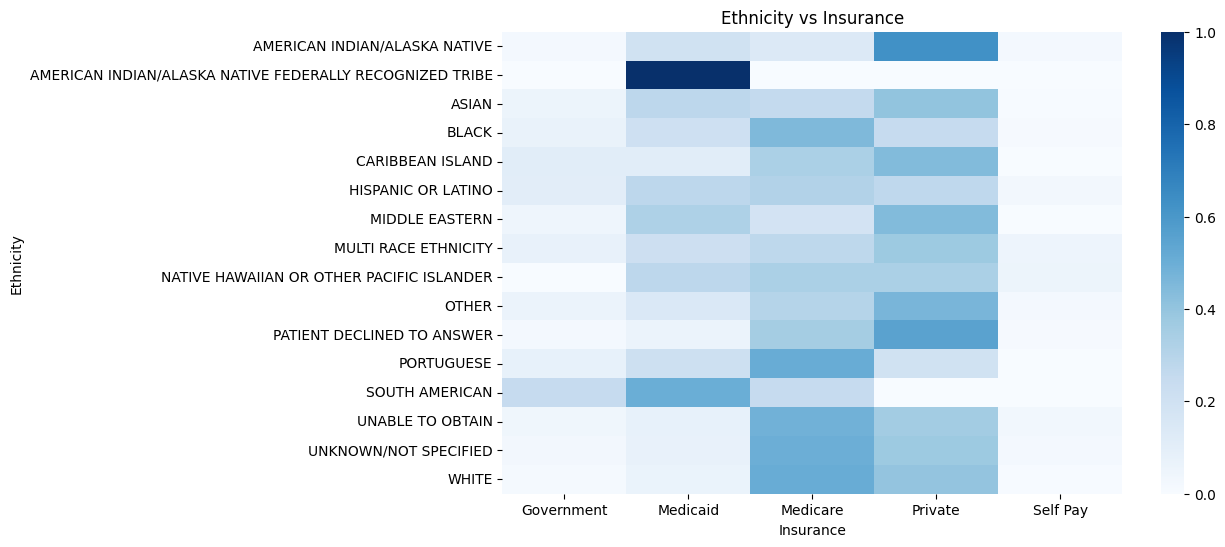

In [28]:
# visualise in heatmap correlation between ethnicity and insurance
data_ethnicity_insurance = pd.crosstab(admissions_df['ETHNICITY_GROUP'], admissions_df['INSURANCE'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_ethnicity_insurance, cmap='Blues')
plt.title('Ethnicity vs Insurance')
plt.xlabel('Insurance')
plt.ylabel('Ethnicity')
plt.show()

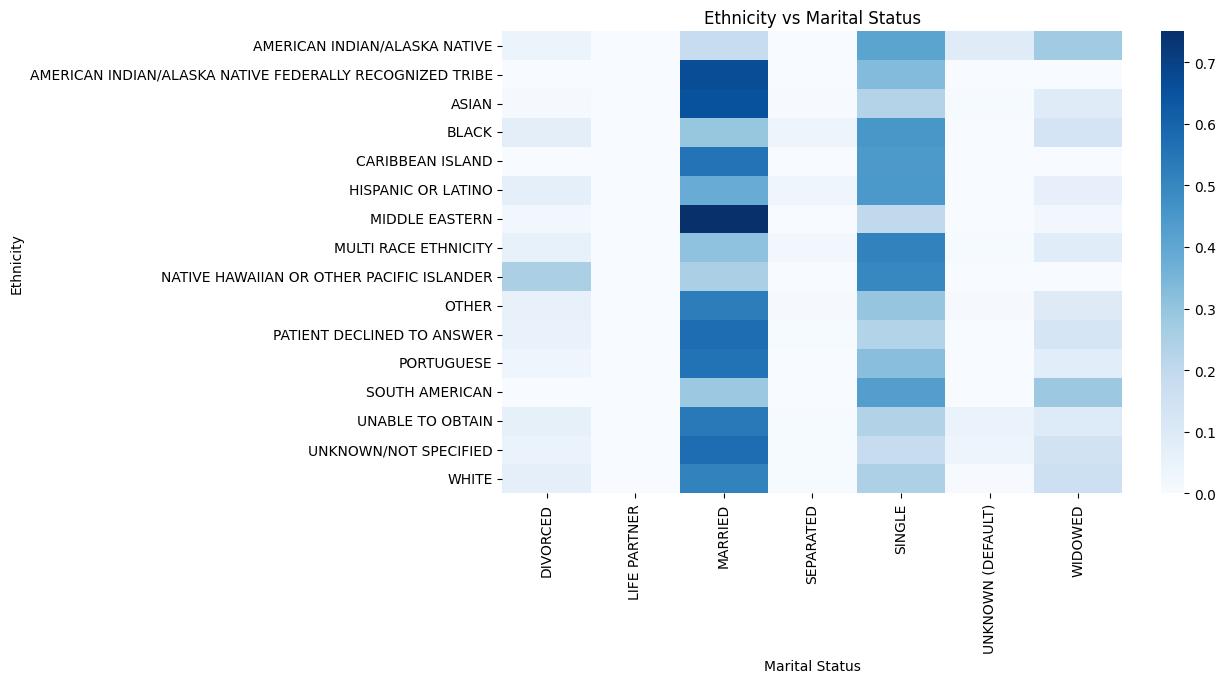

In [29]:
# visualise in heatmap correlation between ethnicity group and marital status
data_ethnicity_marital_status = pd.crosstab(admissions_df['ETHNICITY_GROUP'], admissions_df['MARITAL_STATUS'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_ethnicity_marital_status, cmap='Blues')
plt.title('Ethnicity vs Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Ethnicity')
plt.show()

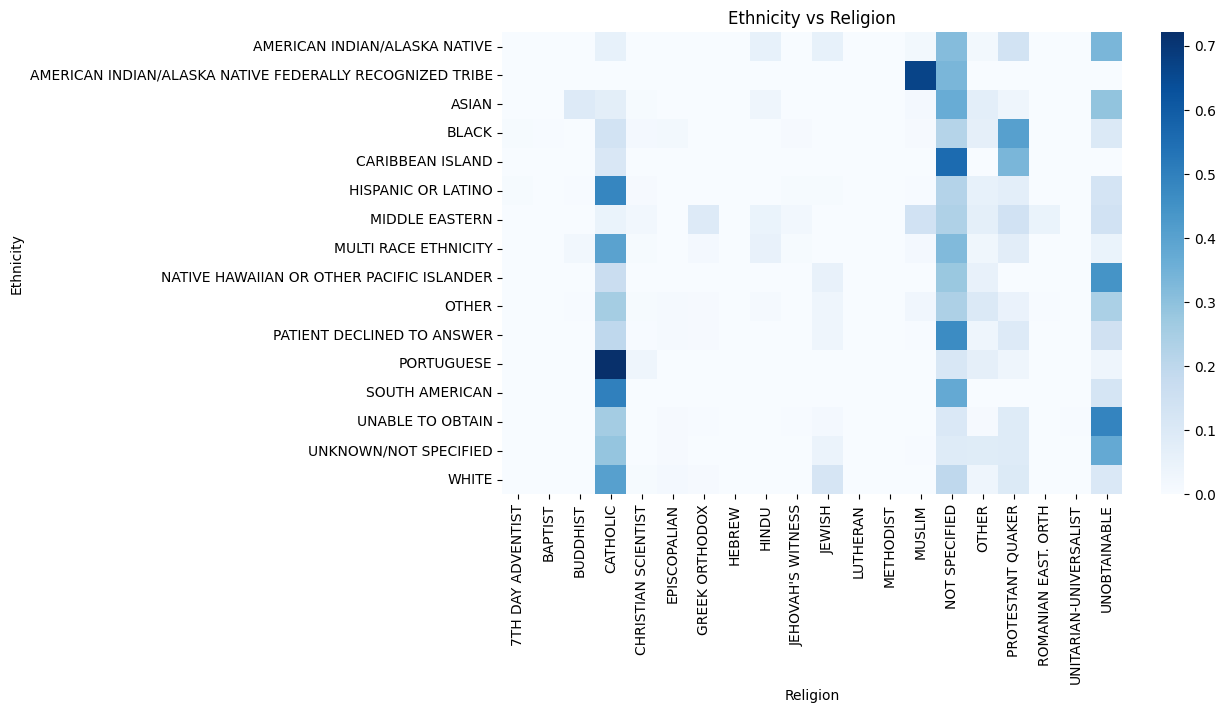

In [30]:
# visualise in heatmap correlation between ethnicity group and religion
data_ethnicity_insurance = pd.crosstab(admissions_df['ETHNICITY_GROUP'], admissions_df['RELIGION'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_ethnicity_insurance, cmap='Blues')
plt.title('Ethnicity vs Religion')
plt.xlabel('Religion')
plt.ylabel('Ethnicity')
plt.show()

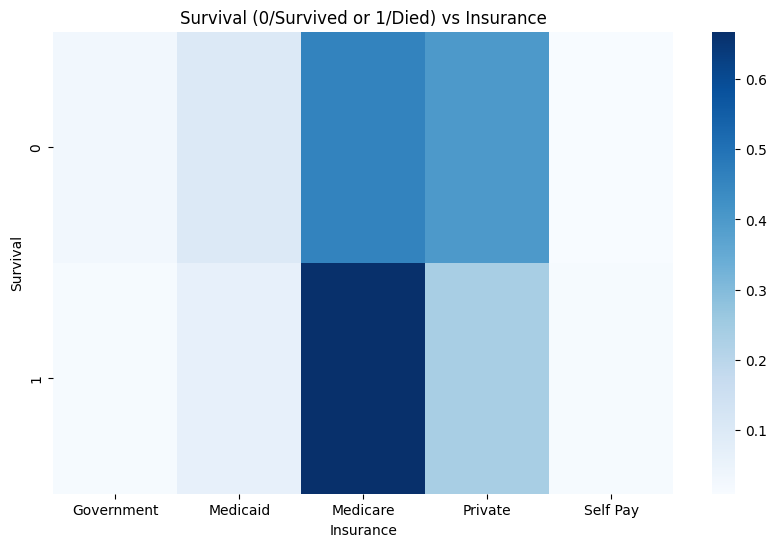

In [31]:
# visualise in heatmap correlation between survival and insurance
data_religion_insurance = pd.crosstab(admissions_df['HOSPITAL_EXPIRE_FLAG'], admissions_df['INSURANCE'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_religion_insurance, cmap='Blues')
plt.title('Survival (0/Survived or 1/Died) vs Insurance')
plt.xlabel('Insurance')
plt.ylabel('Survival')
plt.show()

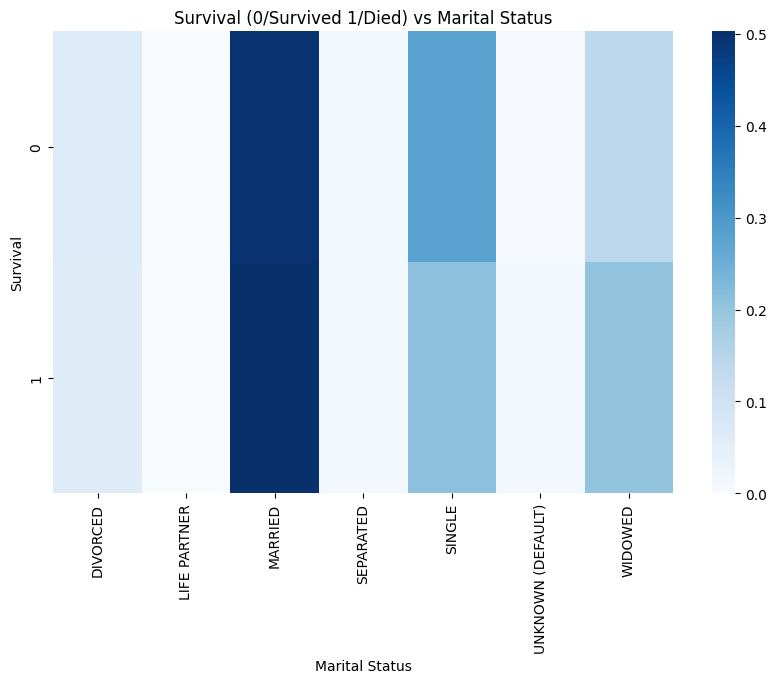

In [32]:
# visualise in heatmap correlation between survival and marital status
data_religion_insurance = pd.crosstab(admissions_df['HOSPITAL_EXPIRE_FLAG'], admissions_df['MARITAL_STATUS'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_religion_insurance, cmap='Blues')
plt.title('Survival (0/Survived 1/Died) vs Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Survival')
plt.show()

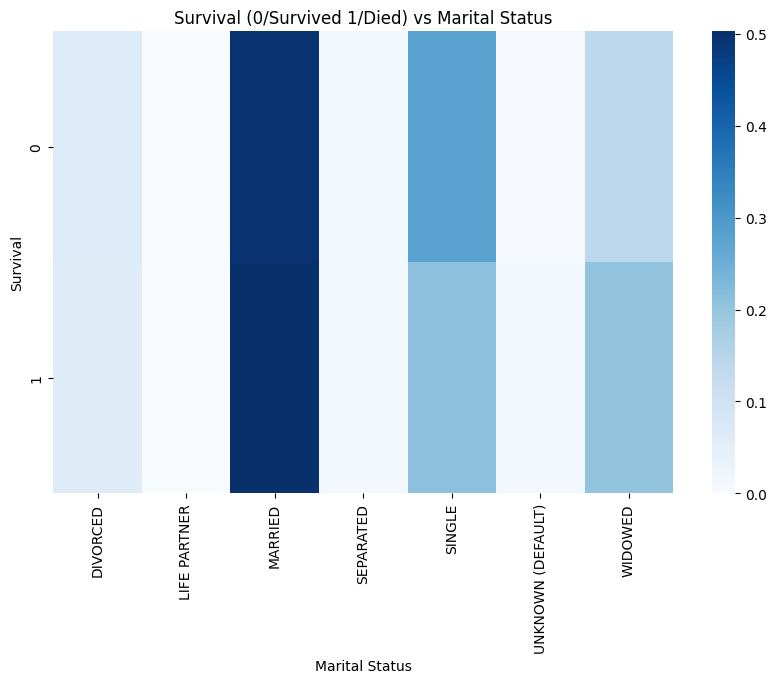

In [33]:
# visualise in heatmap correlation between survival and marital status
data_insurance_marital_status = pd.crosstab(admissions_df['HOSPITAL_EXPIRE_FLAG'], admissions_df['MARITAL_STATUS'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(data_insurance_marital_status, cmap='Blues')
plt.title('Survival (0/Survived 1/Died) vs Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Survival')
plt.show()

EXPLORE PATIENTS DATASET

In [34]:
# load patients dataset into memory and preview info and dataframe
patients_df = load_file_results_to_df(file_path=file_list[21])
# describe patients datafame and review first few rows
patients_df.info()
patients_df.head(10)

DataFrame with 46520 row(s) has been returned.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
5,239,255,M,2109-08-05 00:00:00,NaN,NaN,NaN,0
6,240,256,M,2086-07-31 00:00:00,NaN,NaN,NaN,0
7,241,257,F,2031-04-03 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,1
8,242,258,F,2124-09-19 00:00:00,NaN,NaN,NaN,0
9,243,260,F,2105-03-23 00:00:00,NaN,NaN,NaN,0


In [35]:
# check for duplicate patients
duplicate_subject_id_count = patients_df.duplicated(subset=['SUBJECT_ID']).sum()
print(f"Number of duplicate SUBJECT_IDs is: {duplicate_subject_id_count}")

Number of duplicate SUBJECT_IDs is: 0


In [36]:
# reviewing missingness across the patients dataset
patients_null_values_df = patients_df.isnull().sum().reset_index()
patients_null_values_df.columns = ['Column', 'Missing Count']
patients_null_values_df.sort_values(by='Missing Count', ascending=False)

,Column,Missing Count
5,DOD_HOSP,36546
6,DOD_SSN,33142
4,DOD,30761
0,ROW_ID,0
3,DOB,0
2,GENDER,0
1,SUBJECT_ID,0
7,EXPIRE_FLAG,0


In [37]:
# check for duplicate patient records
duplicate_subject_id_count = patients_df.duplicated(subset=['SUBJECT_ID']).sum()
print(f"Number of duplicate SUBJECT_IDs is: {duplicate_subject_id_count}")

Number of duplicate SUBJECT_IDs is: 0


In [38]:
gender_counts = patients_df['GENDER'].value_counts()
gender_counts

,count
GENDER,
M,26121
F,20399


In [39]:
survival_counts = patients_df['EXPIRE_FLAG'].value_counts()
survival_counts

,count
EXPIRE_FLAG,
0,30761
1,15759


In [40]:
# join admissions and patients datasets
joined_admissions_patients_df = admissions_df.merge(patients_df, on='SUBJECT_ID', how='left')
joined_admissions_patients_df.info()
joined_admissions_patients_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID_x              58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ETHNICITY_GROUP,HOSPITAL_LENGTH,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,WHITE,1,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,WHITE,5,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,WHITE,7,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,WHITE,3,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,WHITE,4,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,1,UNKNOWN/NOT SPECIFIED,7,23,M,2054-05-04 00:00:00,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,1,WHITE,3,24,F,2191-11-30 00:00:00,NaN,NaN,NaN,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,WHITE,5,25,M,2103-04-15 00:00:00,NaN,NaN,NaN,0
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,UNKNOWN/NOT SPECIFIED,5,26,M,1872-10-14 00:00:00,NaN,NaN,NaN,0
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,WHITE,8,27,M,2036-05-17 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1


In [41]:
# cast datetime columns to datetime and drop any with missing values that are needed
joined_admissions_patients_df['ADMITTIME'] = pd.to_datetime(joined_admissions_patients_df['ADMITTIME'])
joined_admissions_patients_df['DOB'] = pd.to_datetime(joined_admissions_patients_df['DOB'])
joined_admissions_patients_df = joined_admissions_patients_df.dropna(subset=['ADMITTIME', 'DOB'])

In [42]:
joined_admissions_patients_df.head(10)

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ETHNICITY_GROUP,HOSPITAL_LENGTH,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,WHITE,1,19,F,2131-05-07,NaN,NaN,NaN,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,WHITE,5,20,M,2082-07-17,NaN,NaN,NaN,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,WHITE,7,20,M,2082-07-17,NaN,NaN,NaN,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,WHITE,3,21,M,2100-05-31,NaN,NaN,NaN,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,WHITE,4,22,M,2101-11-21,NaN,NaN,NaN,0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,1,UNKNOWN/NOT SPECIFIED,7,23,M,2054-05-04,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,1,WHITE,3,24,F,2191-11-30,NaN,NaN,NaN,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,WHITE,5,25,M,2103-04-15,NaN,NaN,NaN,0
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,UNKNOWN/NOT SPECIFIED,5,26,M,1872-10-14,NaN,NaN,NaN,0
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,WHITE,8,27,M,2036-05-17,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1


In [43]:
# check max min values for ADMITTIME
print(pd.to_datetime(joined_admissions_patients_df['ADMITTIME']).max())
print(pd.to_datetime(joined_admissions_patients_df['ADMITTIME']).min())

2210-08-17 17:13:00
2100-06-07 19:59:00


In [44]:
# check max min values for DOB
print(pd.to_datetime(joined_admissions_patients_df['DOB']).max())
print(pd.to_datetime(joined_admissions_patients_df['DOB']).min())


2201-07-24 00:00:00
1800-07-02 00:00:00


In [45]:
# remove those items where admission time is before dob birth - errors
joined_admissions_patients_df = joined_admissions_patients_df[joined_admissions_patients_df['ADMITTIME'] > joined_admissions_patients_df['DOB']]
joined_admissions_patients_df.info()
joined_admissions_patients_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 58969 entries, 0 to 58975
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID_x              58969 non-null  int64         
 1   SUBJECT_ID            58969 non-null  int64         
 2   HADM_ID               58969 non-null  int64         
 3   ADMITTIME             58969 non-null  datetime64[ns]
 4   DISCHTIME             58969 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   ADMISSION_TYPE        58969 non-null  object        
 7   ADMISSION_LOCATION    58969 non-null  object        
 8   DISCHARGE_LOCATION    58969 non-null  object        
 9   INSURANCE             58969 non-null  object        
 10  LANGUAGE              33641 non-null  object        
 11  RELIGION              58511 non-null  object        
 12  MARITAL_STATUS        48847 non-null  object        
 13  ETHNICITY            

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ETHNICITY_GROUP,HOSPITAL_LENGTH,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,WHITE,1,19,F,2131-05-07,NaN,NaN,NaN,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,WHITE,5,20,M,2082-07-17,NaN,NaN,NaN,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,WHITE,7,20,M,2082-07-17,NaN,NaN,NaN,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,WHITE,3,21,M,2100-05-31,NaN,NaN,NaN,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,WHITE,4,22,M,2101-11-21,NaN,NaN,NaN,0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,1,UNKNOWN/NOT SPECIFIED,7,23,M,2054-05-04,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,1,WHITE,3,24,F,2191-11-30,NaN,NaN,NaN,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,WHITE,5,25,M,2103-04-15,NaN,NaN,NaN,0
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,UNKNOWN/NOT SPECIFIED,5,26,M,1872-10-14,NaN,NaN,NaN,0
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,WHITE,8,27,M,2036-05-17,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1


In [46]:
# covert to workable times and then calculate age of patient in years
joined_admissions_patients_df['DOB_PY'] = joined_admissions_patients_df['DOB'].apply(lambda x: x.to_pydatetime())
joined_admissions_patients_df['ADMITTIME_PY'] = joined_admissions_patients_df['ADMITTIME'].apply(lambda x: x.to_pydatetime())

joined_admissions_patients_df['DOB_ORD'] = joined_admissions_patients_df['DOB_PY'].apply(lambda x: x.toordinal())
joined_admissions_patients_df['ADMITTIME_ORD'] = joined_admissions_patients_df['ADMITTIME_PY'].apply(lambda x: x.toordinal())

joined_admissions_patients_df['AGE_DAYS'] = joined_admissions_patients_df['ADMITTIME_ORD'] - joined_admissions_patients_df['DOB_ORD']
joined_admissions_patients_df['AGE_YEARS'] = (joined_admissions_patients_df['AGE_DAYS'] / 365.25).astype(int)

joined_admissions_patients_df


Output hidden; open in https://colab.research.google.com to view.

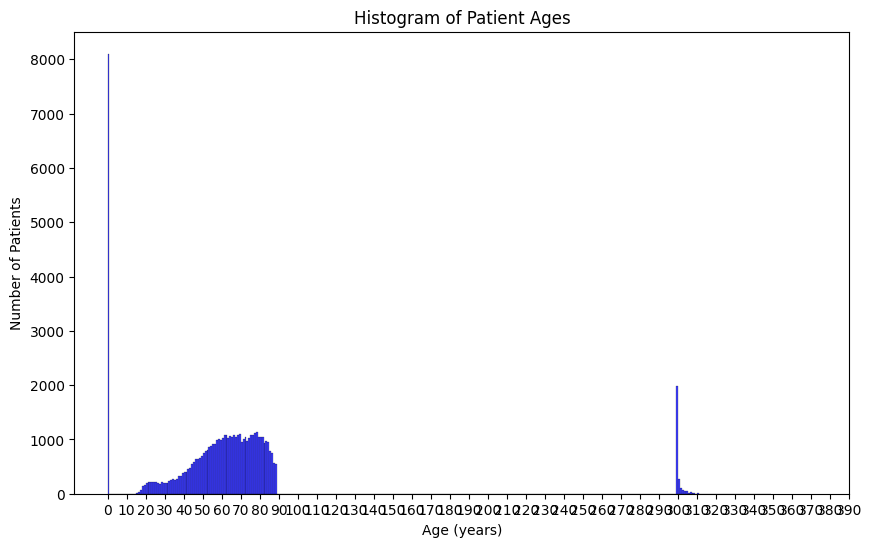

In [47]:
# visualise patient ages on histogram
plt.figure(figsize=(10, 6))
sns.histplot(joined_admissions_patients_df['AGE_YEARS'], bins=range(0,350), color='blue')
plt.title('Histogram of Patient Ages')
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.xticks(range(0,400,10))
plt.show()

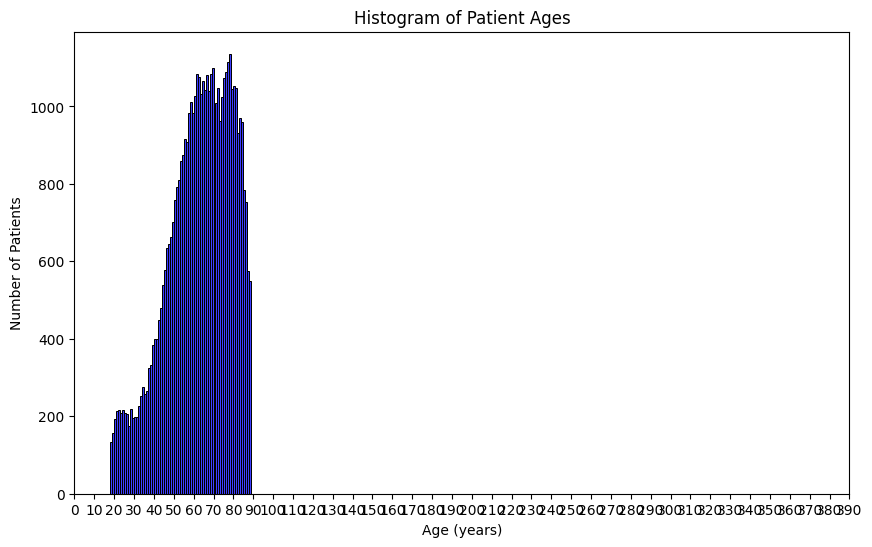

In [48]:
# visualise patient ages on histogram
plt.figure(figsize=(10, 6))
sns.histplot(joined_admissions_patients_df['AGE_YEARS'], bins=range(18,90), color='blue')
plt.title('Histogram of Patient Ages')
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.xticks(range(0,400,10))
plt.show()